# Module Graphics
This Notebook is for developing the graphics for individual modules, showing our rating of their risk to ChatGPT and summarising their assessment types. It also demonstrates exactly how their rating was generated.

## Imports
Here is code we will need, either importing packages or input files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json
import matplotlib.ticker as mtick
import plotly.express as px
from fpdf import FPDF 
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

The below function handles files that were saved by the Module Scraper Code. It is a helper function that we use to access these files in other functions.

In [2]:
#This finds files that were saved by the Module Scraper Code
def file_finder(school=None, level=None, givenList=None, filename=None, module=None):
    #Set the path to the overall directory with our input files
    dir_raw=Path.Path("ModuleInformation")
    
    #This locates the subdirectory where files by school, level or list can be found
    subdirectory=""
    #Set the subdirectory 
    if level != None:
        subdirectory+= "Level=%d" %(level)
    if school != None:
        subdirectory+= "_School="+school.replace(" ", "-")
    if filename != None:
        subdirectory = filename
    if module != None:
        subdirectory = ("IndividualModules/%s" %module)
        
    #If a subdirectory has indeed been set, change the path to reflect this
    if len(subdirectory) > 0:
        dir_raw =dir_raw / subdirectory
        

    #Read the files for the assessment and descriptors in, closing the file immediately after
    with open(dir_raw / "assessments.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            assessments=pd.read_json(infile, orient="columns")
        else:
            assessments=pd.read_json(infile)
    with open(dir_raw / "descriptors.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            descriptors=pd.read_json(infile, typ="series")
        else:
            descriptors=pd.read_json(infile)
    
    assessments["Level"]=assessments["Level"].apply(lambda x: pd.to_numeric(x.split('(')[0], errors='ignore'))
    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    #assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    #assessments["Stage"]=assessments["Stage"].replace("M", 4)
    assessments["Student Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)*assessments["Enrolled Students 22/23"]
    assessments["Assessment Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)
    #Return the desired assessment and description information
    return assessments, descriptors

Just to check that its working, we will print out the information for the entire college of Engineering and Architecture.

In [3]:
#Test the file finder function 
assessments, descriptors = file_finder()

assessments

Reading from ModuleInformation
Reading from ModuleInformation


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,Level,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Module Title,Stage,Student Credits,Assessment Credits
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Blended,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,74.0,2.00
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,1,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,968.5,3.25
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Blended,1,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,149.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,14.00
1272,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,2.00
1273,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,6.00
1274,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,3.00


## Graphing Tools

Below is a python dictionary that associates each assessment type with a susceptibility to ChatGPT value. These can easily be changed or updated as this project progresses.


In [4]:
susceptibility={"Assignment" :5, \
                "Attendance": 0, \
                "Class Test" : 0, \
                "Continuous Assessment": 5, \
               "Essay": 5, \
                "Examination": 0, \
                "Fieldwork": 0, \
                "Group Project": 3, \
                "Journal": 3,\
               "Lab Report": 2, \
                "Multiple Choice Questionnaire": 2, \
                "Oral Examination": 0, \
               "Portfolio" : 2.5,  \
                "Practical Examination": 0, \
                "Presentation" : 0, \
                "Project": 5, \
               "Seminar": 0, \
               "Studio Examination" : 0,\
                   "Assessments worth <2%": None}

In [5]:
work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Blended", \
                "Journal": "Blended",\
               "Lab Report": "Blended", \
                "Multiple Choice Questionnaire": "Blended", \
                "Oral Examination": "In person", \
               "Portfolio" : "Blended",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

Next we will add in the susceptibility rating for each assignment.

In [6]:
assessments["Exposure Estimate"]=assessments["Assessment Type"].apply(lambda x: susceptibility[x])*(assessments["% of Final Grade"]/100)

print(assessments["Exposure Estimate"].isna().sum())

assessments

0


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,...,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Module Title,Stage,Student Credits,Assessment Credits,Exposure Estimate
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,...,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50,0.0
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,...,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,55.5,1.50,0.0
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Blended,...,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,Energy Climate Change & Policy,NaN,74.0,2.00,0.8
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,...,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,968.5,3.25,0.0
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Blended,...,5.0,Electrical & Electronic Eng,Professor Simon Kelly,Autumn,298,Electronic&Electrical I,NaN,149.0,0.50,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,...,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,14.00,3.5
1272,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,...,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research II,NaN,0.0,2.00,0.5
1273,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,...,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,6.00,1.0
1274,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,...,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,Industrial Research III,NaN,0.0,3.00,0.5


Below is a function designed to build charts for a given module set. It identifies which of those modules are using assessment types that are susceptible to ChatGPT and what percentage such assessments are of the overall assessment type. It also publishes below a bar chart that shows the breakdown of assessment types.


In [7]:
#Builds a graph to indicate the susceptibility of a module set's assessments to Chat GPT
def workType_builder(assessments, scaled=True, school=None, level=None, givenList=None, filename=None, \
                     module=None, time=False, student_credits=False, with_internships=True):
    
    num_unique=len(assessments["Module Code"].unique())
    #Data Cleaning and Manipulation Part
    #########################################################################################
    #First we will reduce the assessments dataframe to just the columns we require here.
    if with_internships != True:
        Datasets=Path.Path("Datasets")
        internship_file= Datasets / "UCD_EngArch_InternshipModules.xlsx"
        internships=pd.read_excel(internship_file)

        new_assessments=assessments[~assessments["Module Code"].isin(internships["Code"])]
    else:
        new_assessments=assessments
    
    #For the pie chart, group by susceptibilty
    assessment_sus=new_assessments.groupby(by="Work Type").sum()
    #For the bar chart, group by assessment type
    assessment_total=new_assessments.groupby("Assessment Type").sum()

    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    elif scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_sus[assessment_scale].sum()

    #Get the percentage each assessment type makes up of the overall for both graphs
    assessment_sus["% of Assessment"]=assessment_sus[assessment_scale].apply(lambda x: x/total)
    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)

    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    assessment_total["Work Type"]=assessment_total.index.map(lambda x: work_type[x])

    #Sort the totals into descending order, to make it easier to see
    sorted_totals=assessment_total.sort_values(by="% of Assessment", ascending=False)
    #The groupby function removed the categorical "Susceptibility" column. Bring it back
    sorted_totals["Work Type"]=sorted_totals.index.map(lambda x: work_type[x])

    #Graph building part
    #############################################################################################################
    #Set the font
    plt.rcParams["font.family"] = "sans"
    
    #Make the figure
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 9))

    #Make a pie chart on the desired axes
    if time == False:
        fig, ax=workType_pie(assessment_sus, fig, ax, num_unique)
    else:
        stage=False
        if filename != None:
            stage=True
        #Make the area level stacked chart
        fig, ax=workType_stackedBar(new_assessments, fig, ax, stage=stage, student_credits=student_credits)
        
    #Make the horizontal bar chart on the desired axes
    fig, bx=workType_barh(sorted_totals, fig, bx)
    
    #Here we want to set the overall title of the charts - to indicate what module subset they are describing
    what="the College of Engineering and Architecture"
    if school != None:
        what=""
        what+="the School of "
        what+=school
    if level != None:
        what+= " At Level %d" %level
    if filename != None:
        what="the ".join([(" "+i if i.isupper() else i) for i in filename])
    if module != None:
        what = module 
    if not with_internships:
        what = what + " Excluding Internships"

        
    #Set the overall title for the two graphs
    fig.suptitle("Assessment Breakdown in %s" %what, fontsize=24)
    fig.tight_layout()
    
    if not time: 
        what = what + " Snapshot"
    
    
    #Describe what the figure is
    what=what.replace(" ", "-")
    
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "WorkType"
    if module != None:
        dir_output=dir_output / "Modules"
        what=module
        
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.png" %what)
    plt.savefig(filename, dpi="figure")

This is a function that builds a pie chart as desired, breaking down model assessment by work type.

In [8]:
def workType_pie(assessment_sus, fig, ax, num_unique=None):
        #These are for selecting colours and hatching for each pie segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching for each pie segment
    for segment in assessment_sus.index:
        colours.append(colour_dict[segment])
        hatching.append(hatching_dict[segment])

    #Make the susceptibility pie chart
    ax.pie(assessment_sus["% of Assessment"],\
           wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white', "alpha" : 0.9}, \
           autopct="%1.1f%%", labels=assessment_sus.index, hatch=hatching ,\
           colors=colours, textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    ax.set_title("Proportions of Different Assessment Kinds", fontsize=20)
    
    if num_unique!=None:
        ax.set_xlabel("\n\nNumber of Modules in this Breakdown: %d" %(num_unique), fontsize=20)
    
    return fig, ax

This is a function that creates a horizontal bar chart, break down the assessments by assessment types.

In [9]:
def workType_barh(sorted_totals, fig, bx):
    #These are for selecting colours and hatching for each bar in the bar chart
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching type based on susceptibilty
    for sus in sorted_totals["Work Type"]:
        colours.append(colour_dict[sus])
        hatching.append(hatching_dict[sus])
        
    
    #Make the assessment type breakdown bar chart, with colour and hatching indicating the susceptibility
    bx.barh(sorted_totals.index, sorted_totals["% of Assessment"].apply(lambda x:x*100), edgecolor="white", hatch = hatching ,\
           color=colours, alpha=0.9)
    
    #colors = {'fruit':'red', 'veggie':'green'}         
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', labelsize=16)
    
    fmt = '%d%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    bx.xaxis.set_major_formatter(xticks)
    #ax.legend(fontsize=20)
    bx.set_xlabel("Percentage of Assessment",fontsize=18)
    #Set the title for the bar chart for ease of understanding
    bx.set_title("Assessment Breakdown", fontsize=20)
    
    #Do the legend
    labels = list(colour_dict.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colour_dict[label]) for label in labels]
    bx.legend(handles, labels,fontsize=20)
    
    return fig, bx

In [10]:
def workType_levelArea(assessments, fig, ax, scaled=True, stage=False, student_credits=False):
    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    elif scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
    if stage==False:
        time="Level"
    else:
        time="Stage"
        
    stackedbar=assessments[""]

    #These are for selecting colours and hatching for each area segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    Stackedwork={}

    
    #Get the colours and hatching for each area segment
    for i, segment in enumerate(stackedbar["Work Type"].unique().tolist()):
        Stackedwork[segment]=stackedbar[stackedbar["Work Type"] == segment][assessment_scale].reset_index(drop=True)
        if i ==0:
            Totalwork=Stackedwork[segment]
        else:
            Totalwork=Totalwork+Stackedwork[segment]
        colours.append(colour_dict[segment])
        #hatching.append(hatching_dict[segment])
    
    ax.stackplot(assessments["Level"].unique().tolist(), Stackedwork["At home"]/Totalwork,  Stackedwork["Blended"]/Totalwork, \
                  Stackedwork["In person"]/Totalwork, colors=colours, labels=["At home", "Blended", "In person"])
    
        #Set the options for the axes
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    #ax.legend(fontsize=20)
    ax.set_ylabel("Proportion of Assessment",fontsize=18)
    ax.set_xlabel("%s" %time,fontsize=18)
    ax.legend(fontsize=20)
    #Set the title for the bar chart for ease of understanding
    ax.set_title("Assessment Proportions over %s" %time , fontsize=20)
    
    return fig, ax

In [11]:
def workType_stackedBar(assessments, fig, ax, stage=False, student_credits=False):
    #Choose whether or not you want to scale by credits, or take all modules to be equal, regardless of credits
    if student_credits==True:
        assessment_scale="Student Credits"
    else:
        assessment_scale="Assessment Credits"
        
    if stage==False:
        time="Level"
    else:
        time="Stage"
        
    #assessments[time]=assessments[time].apply(lambda x: "%d" %x)
    categories=np.array(assessments[time].unique())
    print(categories)
    assessments[time]=pd.Categorical(assessments[time], categories=categories, ordered=True)
    stackedbar=assessments.groupby(by=["Work Type", time], as_index=False).sum()
    
    #stackedbar=stackedbar.fillna("0")
    #print(stackedbar)
    
    #These are for selecting colours and hatching for each area segment
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    Stackedwork={}

    
    #Get the colours and hatching for each area segment
    for i, segment in enumerate(stackedbar["Work Type"].unique().tolist()):
        Stackedwork[segment]=stackedbar[stackedbar["Work Type"] == segment][assessment_scale].reset_index(drop=True)
        #print(Stackedwork[segment])
        #try:
        #    if (Stackedwork[segment].empty):
        #        Stackedwork[segment]=[0]*len(assessments[time].unique().tolist())
        #    else:
        #        Stackedwork[segment].fillna(0)
        #except:
        #    if Stackedwork[segment] == None:
        #        Stackedwork[segment]=[0]*len(assessments[time].unique().tolist())
        #    elif None in Stacked[segement]:
        #        index=Stacked[segement].index(None)
        #        Stacked[segement][index]=0
                                      
        #Make sure there is no difference between the x value and the y
        #diff=len(Stackedwork[segment])-len(assessments[time].unique().tolist())
        #for i in range(diff):
        #    print("Here")
        #    Stackedwork[segment][len(Stackedwork[segment])+1]=0.0
            
        if i ==0:
            Totalwork=Stackedwork[segment]
        else:
            Totalwork=Totalwork+Stackedwork[segment]
                                         
                                         
    #print(Totalwork)
    #If any work type are not included in the stacked bar, add in a value for that segment of 0
    for work in ["At home", "Blended", "In person"]: 
        if work not in Stackedwork.keys():
                Stackedwork[work]=np.zeros(len(assessments[time].unique().tolist()))

            
 
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
        (Stackedwork["At home"]), color=colour_dict["At home"])
        
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
           (Stackedwork["Blended"]), \
           bottom=(Stackedwork["At home"]), color=colour_dict["Blended"])
    
    ax.bar(["{}".format(level) for level in assessments[time].unique().tolist()],\
           (Stackedwork["In person"]), \
           bottom=(Stackedwork["Blended"])+(Stackedwork["At home"]), color=colour_dict["In person"])

    # Add percentages as labels to the stacked bars
    for idx in assessments[time].unique().tolist():
        start = 0
        for work in ["At home", "Blended", "In person"]:
            y=Stackedwork[work][idx-1]
            value = Stackedwork[work][idx-1]
            total = Totalwork[idx-1]
            if  y/max(Totalwork)> .05 :
                ax.text(
                x=idx-1,
                y=start + y / 2,
                s=f"{round(100 * value / total, 1)}%",
                fontsize=16,
                ha="center"
                )
            start += y
            
    #Set the options for the axes
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
    #ax.legend(fontsize=20)
    ax.set_ylabel("Taught Student Credits",fontsize=18)
    ax.set_xlabel("%s" %time,fontsize=18)
    #ax.legend(["At home", "Hybrid", "In person"],fontsize=20)
    #Set the title for the bar chart for ease of understanding
    ax.set_title("Assessment Proportions over %s" %time , fontsize=20)
    
    return fig, ax

By combining the "worktypebuilder" function with the "file_finder" function, we have a function that can build graphs immediately after finding the files. This makes it very easy for us going forward.

In [12]:
#This finds files and then builds graphs based on their content
def workType_graphs(school=None, level=None, givenList=None, scaled=True, filename=None, module=None, time=False, \
                   student_credits=False, with_internships=True):
    #Find the desired module subset in the files
    assessments, descriptors = file_finder(school=school, level=level, givenList=givenList, filename=filename, module=module)
    
    #Build a graph describing these module subsets
    workType_builder(assessments, scaled=scaled, school=school, level=level,\
                     givenList=givenList, filename=filename, module=module, time=time, student_credits=student_credits, \
                    with_internships=with_internships)

We will want to go through every module in the college, so we will need a module list.

In [13]:
modules=assessments["Module Code"].unique()

print(modules)

['DSCY10060' 'EEEN10010' 'EEEN10020' 'EEEN20010' 'EEEN20020' 'EEEN20030'
 'EEEN20040' 'EEEN20050' 'EEEN20060' 'EEEN20070' 'EEEN20090' 'EEEN30020'
 'EEEN30030' 'EEEN30050' 'EEEN30060' 'EEEN30070' 'EEEN30090' 'EEEN30110'
 'EEEN30120' 'EEEN30150' 'EEEN30160' 'EEEN30180' 'EEEN30190' 'EEEN30220'
 'EEEN30230' 'EEEN30240' 'EEEN40010' 'EEEN40050' 'EEEN40060' 'EEEN40070'
 'EEEN40080' 'EEEN40090' 'EEEN40100' 'EEEN40110' 'EEEN40120' 'EEEN40130'
 'EEEN40150' 'EEEN40160' 'EEEN40170' 'EEEN40180' 'EEEN40190' 'EEEN40200'
 'EEEN40210' 'EEEN40220' 'EEEN40240' 'EEEN40260' 'EEEN40280' 'EEEN40290'
 'EEEN40300' 'EEEN40310' 'EEEN40350' 'EEEN40360' 'EEEN40550' 'EEEN40570'
 'EEEN40580' 'EEEN40600' 'EEEN40620' 'EEEN40630' 'EEEN40650' 'EEEN40660'
 'EEEN40670' 'EEEN40680' 'EEEN40700' 'EEEN40710' 'EEEN50070' 'EEEN50080'
 'CVEN10040' 'CVEN10050' 'CVEN10060' 'CVEN20010' 'CVEN20030' 'CVEN20040'
 'CVEN20070' 'CVEN20080' 'CVEN20110' 'CVEN20120' 'CVEN20130' 'CVEN20140'
 'CVEN30010' 'CVEN30020' 'CVEN30040' 'CVEN30060' 'C

Now we will loop through the module codes and create an assessment type breakdown visualisation for each

In [14]:
def risk_colour(module, rating):
    #We will create two subplots and a figure to show the ratings
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 5))

    #We will set the colourmap we will use for the ratings
    cmaps = plt.cm.RdYlGn_r

    #Fill a box on the left with the rating colour, and annotate with the rating number
    #ax.imshow( cmaps(rating/5))

    #create rectangle with the rating
    rectangle = Rectangle((0, 0), 0.5, 0.6, edgecolor='black',
    facecolor=cmaps(rating/5), linewidth=2, fill=True)
    ax.add_patch(rectangle)

    #Annotate with the rating number
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry + rectangle.get_height()/2.0
    #add rectangle to plot
    ax.annotate("%.1f" %rating, (cx, cy), color='black', weight='bold', fontsize=36, ha='center', va='center')
    #Hide the axis
    ax.axis("off")
    
    risk=""
    if rating  < 1.5:
        risk = "Low"
        #"Low means that there is little risk of LLM-facilitated cheating in this module."
    elif rating < 3.5:
        risk= "Moderate"
        #"Moderate"
    else:
        risk="Severe"
        #"Severe"
        
    ax.set_title("Exposure Estimate : %.1f - %s" %(rating, risk), fontsize=36)
    
    # create dummy invisible image for the colourbar
    img = bx.imshow(np.array([[0,5]]), cmap=cmaps)
    img.set_visible(False)

    #Set the limits of the x axis to be 0 and 5
    bx.set_xlim(0, 5)

    #Draw the arrow on the axis where desired 
    bx.arrow(x=rating, y=0.2, dx=0, dy=1, head_width=0.4, width=0.2, shape='full', color='black', clip_on=False)

    # create an axes on the right side of ax. The width of cax will be 40%
    # of ax and the padding between cax and ax will be fixed at 0 inch.
    divider = make_axes_locatable(bx)
    cax = divider.append_axes("bottom", size="40%", pad=0)

    #Create the colour bar and set the label size
    cb=plt.colorbar(img, orientation="horizontal", cax=cax, fraction=.5, shrink=1, aspect=3, pad=0)
    cb.ax.tick_params(labelsize=16) 
    #Hide the axis
    bx.axis("off")
    #bx.set_title("Risk Range")

    fig.tight_layout()
    #The functionality to save the risk assessment graphics
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "RiskAssessment"
    if module != None:
        dir_output=dir_output / "Modules"
        what=module
        
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.png" %m)
    plt.savefig(filename, dpi="figure")

DSCY10060
Reading from ModuleInformation\IndividualModules\DSCY10060
Reading from ModuleInformation\IndividualModules\DSCY10060


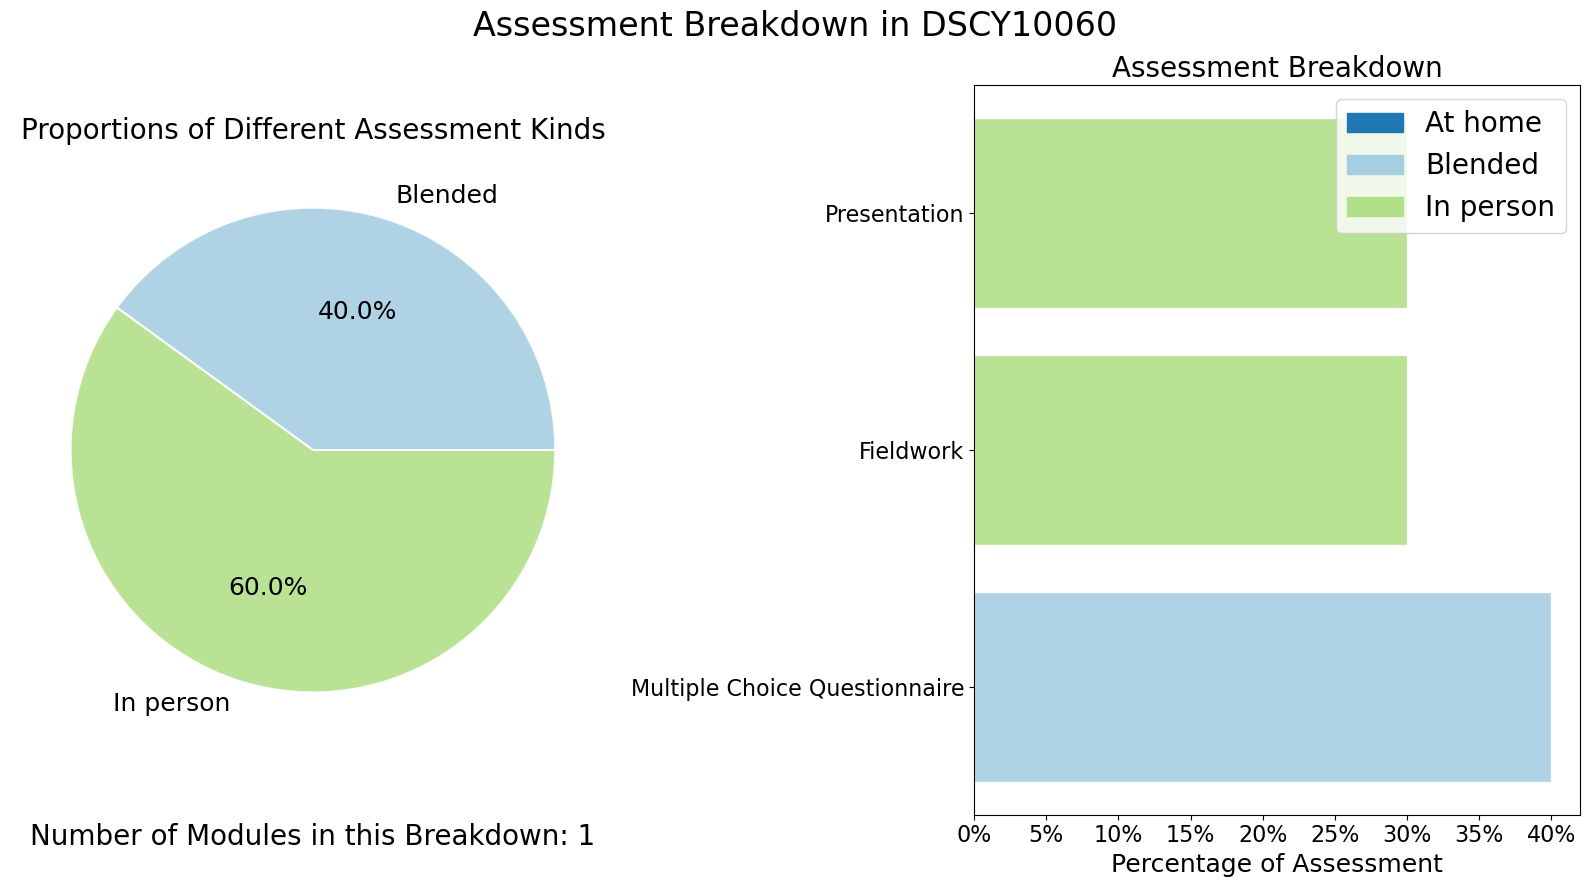

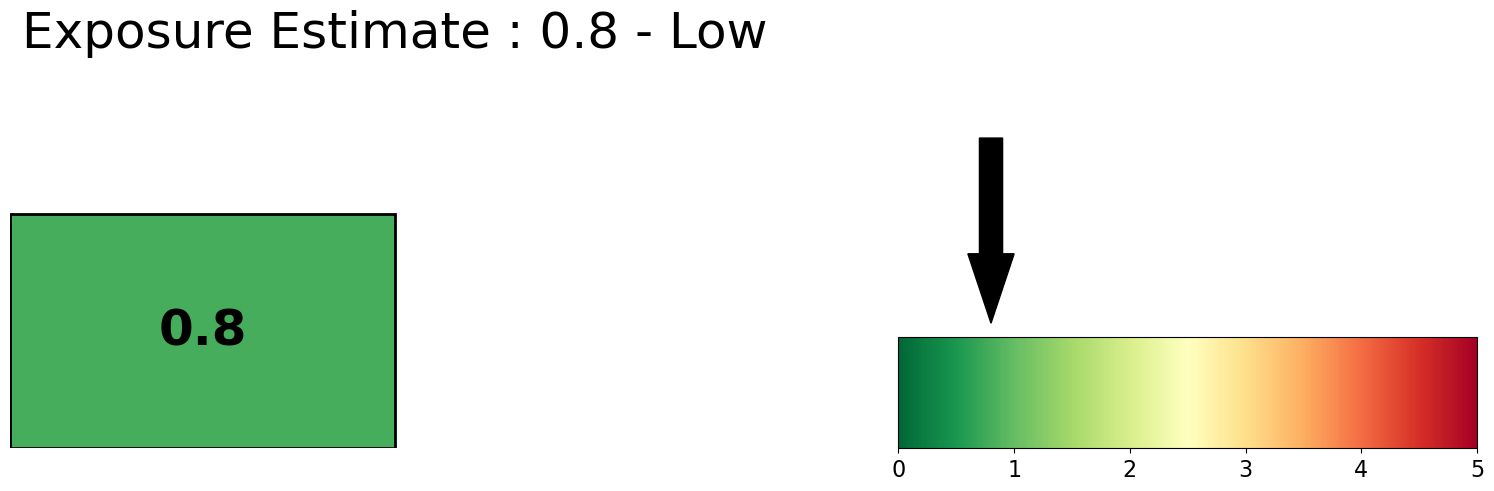

In [15]:
#Create a class for header and footers
class PDF(FPDF):
#Define a nice header for the module
    def header(self):
        #Set the logo
        self.image("UCDLogo.png", 10, 8, 20)
        #Set the font
        self.set_font('helvetica', 'B', 32)
        #A bit of padding
        title_w=self.get_string_width(m) + 6
        doc_w=self.w
        self.set_x((doc_w -title_w)/2)
        #Set the module code
        self.cell(title_w, 10, "%s" %m, ln=True, align='C')
        self.ln(5)
        
        self.set_font('helvetica', 'B', 24)
        
        #Add the module title
        title_w=self.get_string_width(title) + 6
        doc_w=self.w
        self.set_x((doc_w -title_w)/2)
    
        self.cell(title_w, 10,"%s" %(title),0,1, align='C')
        self.ln(10)
        
        
    #def details(self, details):
        
    #def breakdown(self):
        
        
    #Define a footer for the page number we are on
    def footer(self):
        self.set_y(-180)
        
        
        self.image("Graphs\RiskAssessment\Modules\%s.png" %m, 5, 85, 200)
        #self.set_y(-50)
        
        #Set the path to save the graphs
        #dir_output=Path.Path("Graphs")
        #module_breakdown= dir_output / "WorkType" / "Modules" / ("%s.png" % m)
        self.image("Graphs\WorkType\Modules\%s.png" %m, 5, 165, 200)
        
        
        #Set the position of the footer
        self.set_y(-15)
        #Set the font 
        self.set_font('helvetica', 'I', 8)
        #Set the colour to be grey
        self.set_text_color(169, 169, 169)
        #Do the cell with the page number
        self.cell(0, 10, "Page  %s" %self.page_no(), align='C')

modules=assessments["Module Code"].unique()
        
for m in modules:
    ###########################################
    #Make the graphics that we will add into the pdf for the module
    #Make the work_type graphs
    print(m)
    workType_graphs(module=m)
    
    ############################################
    #Get the module details
    details=assessments[assessments["Module Code"]==m]
    
    #Calculate the rating 
    rating=details["Exposure Estimate"].sum()
    #print(details)
    #Make the risk colour and add it to the pdf
    risk_colour(m, rating)
    
    title=details["Module Title"].iloc[0]
    school=details["School"].iloc[0]
    credits=details["Credits"].iloc[0]
    level=details["Level"].iloc[0]
    students=details["Enrolled Students 22/23"].iloc[0]
    
    ############################################
    #Make the pdf report for the module
    pdf = PDF()
    
    #Set the title to the Module Code
    pdf.add_page()
    pdf.set_font('helvetica', 'B', 24)
    
    #The first line of details
    pdf.set_font('helvetica', '', 11)
    
    pdf.cell(40,10, "SCHOOL: %s" %school)
    
    pdf.cell(80)
    pdf.cell(40, 10, "LEVEL: %s" %level, 0, 1)
    
    #The second line of details
    pdf.cell(40, 10, "CREDITS: %s" %credits)
    
    pdf.cell(80)
    pdf.cell(40, 10, "ENROLLED STUDENTS 22/23: %s" %students, 0, 1)
    pdf.ln(10)
    
    pdf.set_font('helvetica', 'UBI', 16)
    pdf.cell(40, 10, "RISK EXPOSURE TO LARGE LANGUAGE MODELS ESTIMATE:", 0, 1)
    
    ################################################
    #Assessments Table
    #pdf.set_font("helvetica", size=11)
    #line_height = pdf.font_size * 2.5
    #col_width = pdf.epw / 4.5

    #lh_list = [] #list with proper line_height for each row
    #use_default_height = 0 #flag

    #create lh_list of line_heights which size is equal to num rows of data
    #for row in data:
    #    for datum in row:
    #        word_list = datum.split()
    #        number_of_words = len(word_list) #how many words
    #        if number_of_words>2: #names and cities formed by 2 words like Los Angeles are ok)
    #            use_default_height = 1
    #            new_line_height = pdf.font_size * (number_of_words/2) #new height change according to data 
    #    if not use_default_height:
    #        lh_list.append(line_height)
    #    else:
    #        lh_list.append(new_line_height)
    #        use_default_height = 0

    #create your fpdf table ..passing also max_line_height!
    #for j,row in enumerate(data):
    #    for datum in row:
    #        line_height = lh_list[j] #choose right height for current row
    #        pdf.multi_cell(col_width, line_height, datum, border=1,align='L',ln=3, 
    #        max_line_height=pdf.font_size)
    #    pdf.ln(line_height)
    #####################################################
    
    #Set the path to save the report
    dir_output=Path.Path("Report")
    #Set the filename for th figure
    dir_output=dir_output / "IndividualModules"
    dir_output.mkdir(parents=True, exist_ok=True)
    filename= dir_output / ("%s.pdf" %m)
    
    
    pdf.output(filename)
    
    break

## Risk Summary Graphs

In [24]:
module_risk=assessments[["Module Code", "Exposure Estimate", "% of Final Grade"]].groupby(by="Module Code").sum()
module_details=assessments[["Module Code", "Enrolled Students 22/23", "School", \
                            "Student Credits", "Credits", "Level", "Module Title"]]\
.groupby(by="Module Code").first()

modules=module_risk.join(module_details)

modules

,Exposure Estimate,% of Final Grade,Enrolled Students 22/23,School,Student Credits,Credits,Level,Module Title
Module Code,,,,,,,,
ARCT10010,2.50,100,72,"Architecture, Plan & Env Pol",1080.0,15.0,1,Architectural Design I
ARCT10020,2.50,100,61,"Architecture, Plan & Env Pol",915.0,15.0,1,Architectural Design II
ARCT10030,5.00,100,78,"Architecture, Plan & Env Pol",195.0,5.0,1,Architecture & its Environment
ARCT10040,1.75,100,61,"Architecture, Plan & Env Pol",122.0,5.0,1,Intro. to Building Envelope
ARCT10070,3.00,100,80,"Architecture, Plan & Env Pol",40.0,5.0,1,Survey Course 1
...,...,...,...,...,...,...,...,...
PLAN40340,5.00,100,10,"Architecture, Plan & Env Pol",50.0,5.0,4,Planning Environ & Public Pol
PLAN40350,5.00,100,8,"Architecture, Plan & Env Pol",48.0,10.0,4,Advanced GIS
PLAN40390,3.60,100,55,"Architecture, Plan & Env Pol",385.0,10.0,4,Sustainable Cities


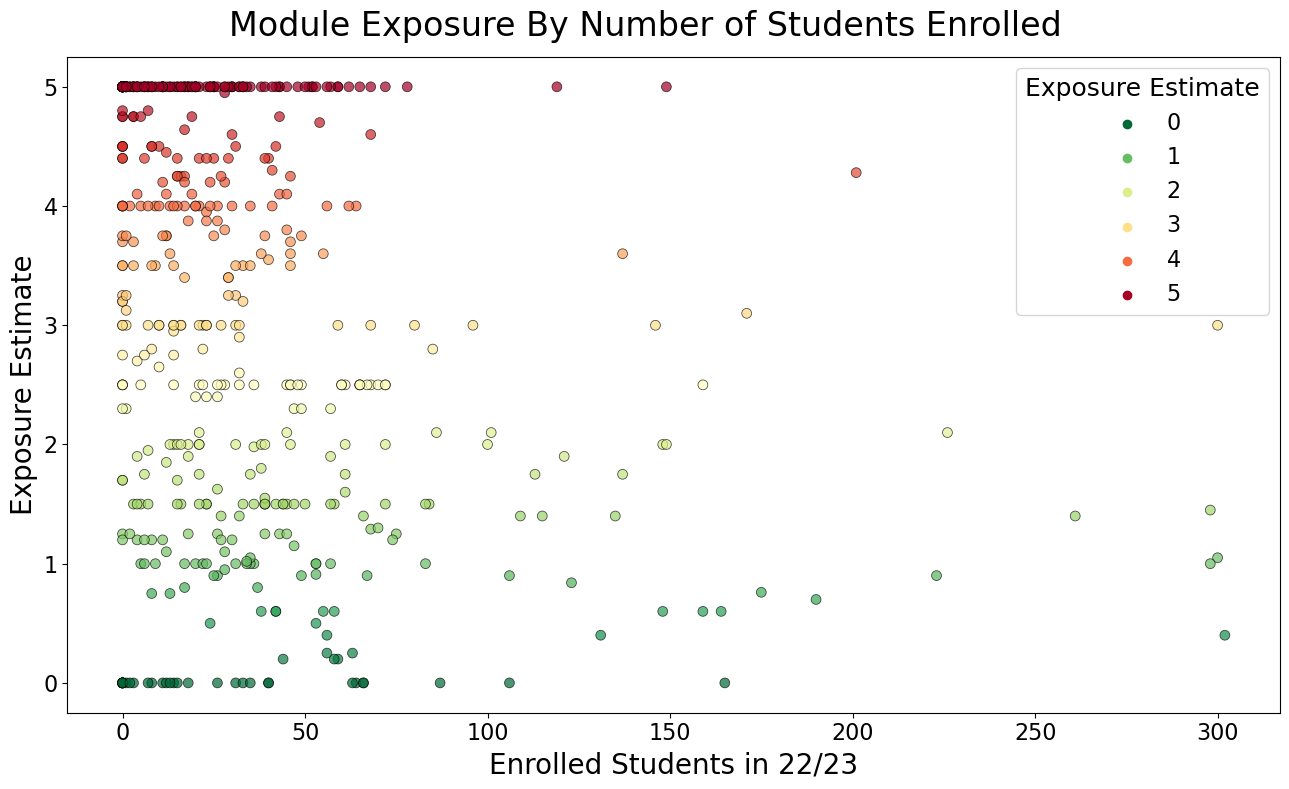

In [90]:
import seaborn as sns

fig=plt.figure(figsize=(13, 8))

sns.scatterplot(data=modules, x="Enrolled Students 22/23", y="Exposure Estimate",\
                hue="Exposure Estimate", palette=plt.cm.RdYlGn_r, s=50, edgecolor="black", alpha=0.7)

#Set the title
fig.suptitle("Module Exposure By Number of Students Enrolled", fontsize=24)

#Format the Axes
plt.ylabel("Exposure Estimate", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Enrolled Students in 22/23", fontsize=20)
plt.legend(title="Exposure Estimate", title_fontsize=18, fontsize=16)
fig.tight_layout()


#Set the path to save the graphs
dir_output=Path.Path("Graphs")
#Set the filename for th figure
dir_output=dir_output / "RiskAssessment" / "Summary"
dir_output.mkdir(parents=True, exist_ok=True)
filename= dir_output / ("ModulesScatter.png")
plt.savefig(filename, dpi=1200)

In [94]:
#These are the paths that exist in the College of Engineering and Architecture
paths=["CivilMastersPath", "MechanicalMastersPath", "BiomedMechanicalMastersPath", \
       "ChemicalEngineeringMastersPath", "ArchitecturePath", "ElectronicMastersPath",\
       "ElectricalMastersPath", "BiomedElectronicMastersPath", "BiomedMechanicalMastersPath"]

paths_string={"CivilMastersPath": "Civil Masters", \
              "MechanicalMastersPath": "Mechanical Masters", \
              "BiomedMechanicalMastersPath": "Biomed Mechanical Masters", \
       "ChemicalEngineeringMastersPath" : "Chemical Masters", \
              "ArchitecturePath": "Architecture Path", \
              "ElectronicMastersPath": "Electronic Masters",\
       "ElectricalMastersPath": "Electrical Masters",\
              "BiomedElectronicMastersPath" : "Biomed Electronic Masters"}
lowest=10
highest=-5
path_total=0
path_count=0

all_paths=[]

path_high=None
path_low=None
path_rating={}

#Go through all the paths
for path in paths:
    #Get their module assessments
    assessment_info, descriptors=file_finder(filename=path)
    
    #Add in the risk rating
    assessment_info["Exposure Estimate"]=assessment_info["Assessment Type"].apply(lambda x: susceptibility[x])\
    *(assessment_info["% of Final Grade"]/100)
    
    #Manipulate the dataframe to get module risk ratings
    module_risk=assessment_info[["Module Code", "Exposure Estimate", "% of Final Grade"]].groupby(by="Module Code").sum()
    module_details=assessment_info[["Module Code", "Enrolled Students 22/23", "School", "Student Credits", "Credits"]]\
    .groupby(by="Module Code").first()

    #Join the two module information types, the numerical and the categorical
    path_ms=module_risk.join(module_details)
    
    #print(path_ms)
    
    #Get the path average
    path_avg=path_ms["Exposure Estimate"].mean()
    #Get the paths count and total
    path_total+=path_ms["Exposure Estimate"].sum()
    path_count+=len(path_ms)
    #Get a module holder by path
    path_ms["Path"]=paths_string[path]
    path_rating[path]=path_avg
    all_paths.append(path_ms)
    
    #Update if the path average is higher than the current highest
    if path_avg > highest:
        #Update the highest and save the school 
        highest=path_avg
        path_high=path
        
    #Repeat above but for the lowest
    if path_avg < lowest:
        lowest=path_avg
        path_low=path
        
print("The path with the lowest mean is %s with a mean of %0.2f" %(path_low, lowest))
print("The path with the highest mean is %s with a mean of %0.2f" %(path_high, highest))
print("The average rating across all paths is %0.2f" %(path_total/path_count))
print(path_count)

paths_df=pd.concat(all_paths, ignore_index=True)
print(len(paths_df))

print(paths_df["Path"].isna().sum())

for path in paths:
    print("The rating for %s is %0.2f" %(path, path_rating[path]))

Reading from ModuleInformation\CivilMastersPath
Reading from ModuleInformation\CivilMastersPath
Reading from ModuleInformation\MechanicalMastersPath
Reading from ModuleInformation\MechanicalMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
Reading from ModuleInformation\ChemicalEngineeringMastersPath
Reading from ModuleInformation\ChemicalEngineeringMastersPath
Reading from ModuleInformation\ArchitecturePath
Reading from ModuleInformation\ArchitecturePath
Reading from ModuleInformation\ElectronicMastersPath
Reading from ModuleInformation\ElectronicMastersPath
Reading from ModuleInformation\ElectricalMastersPath
Reading from ModuleInformation\ElectricalMastersPath
Reading from ModuleInformation\BiomedElectronicMastersPath
Reading from ModuleInformation\BiomedElectronicMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
Reading from ModuleInformation\BiomedMechanicalMastersPath
The path wit

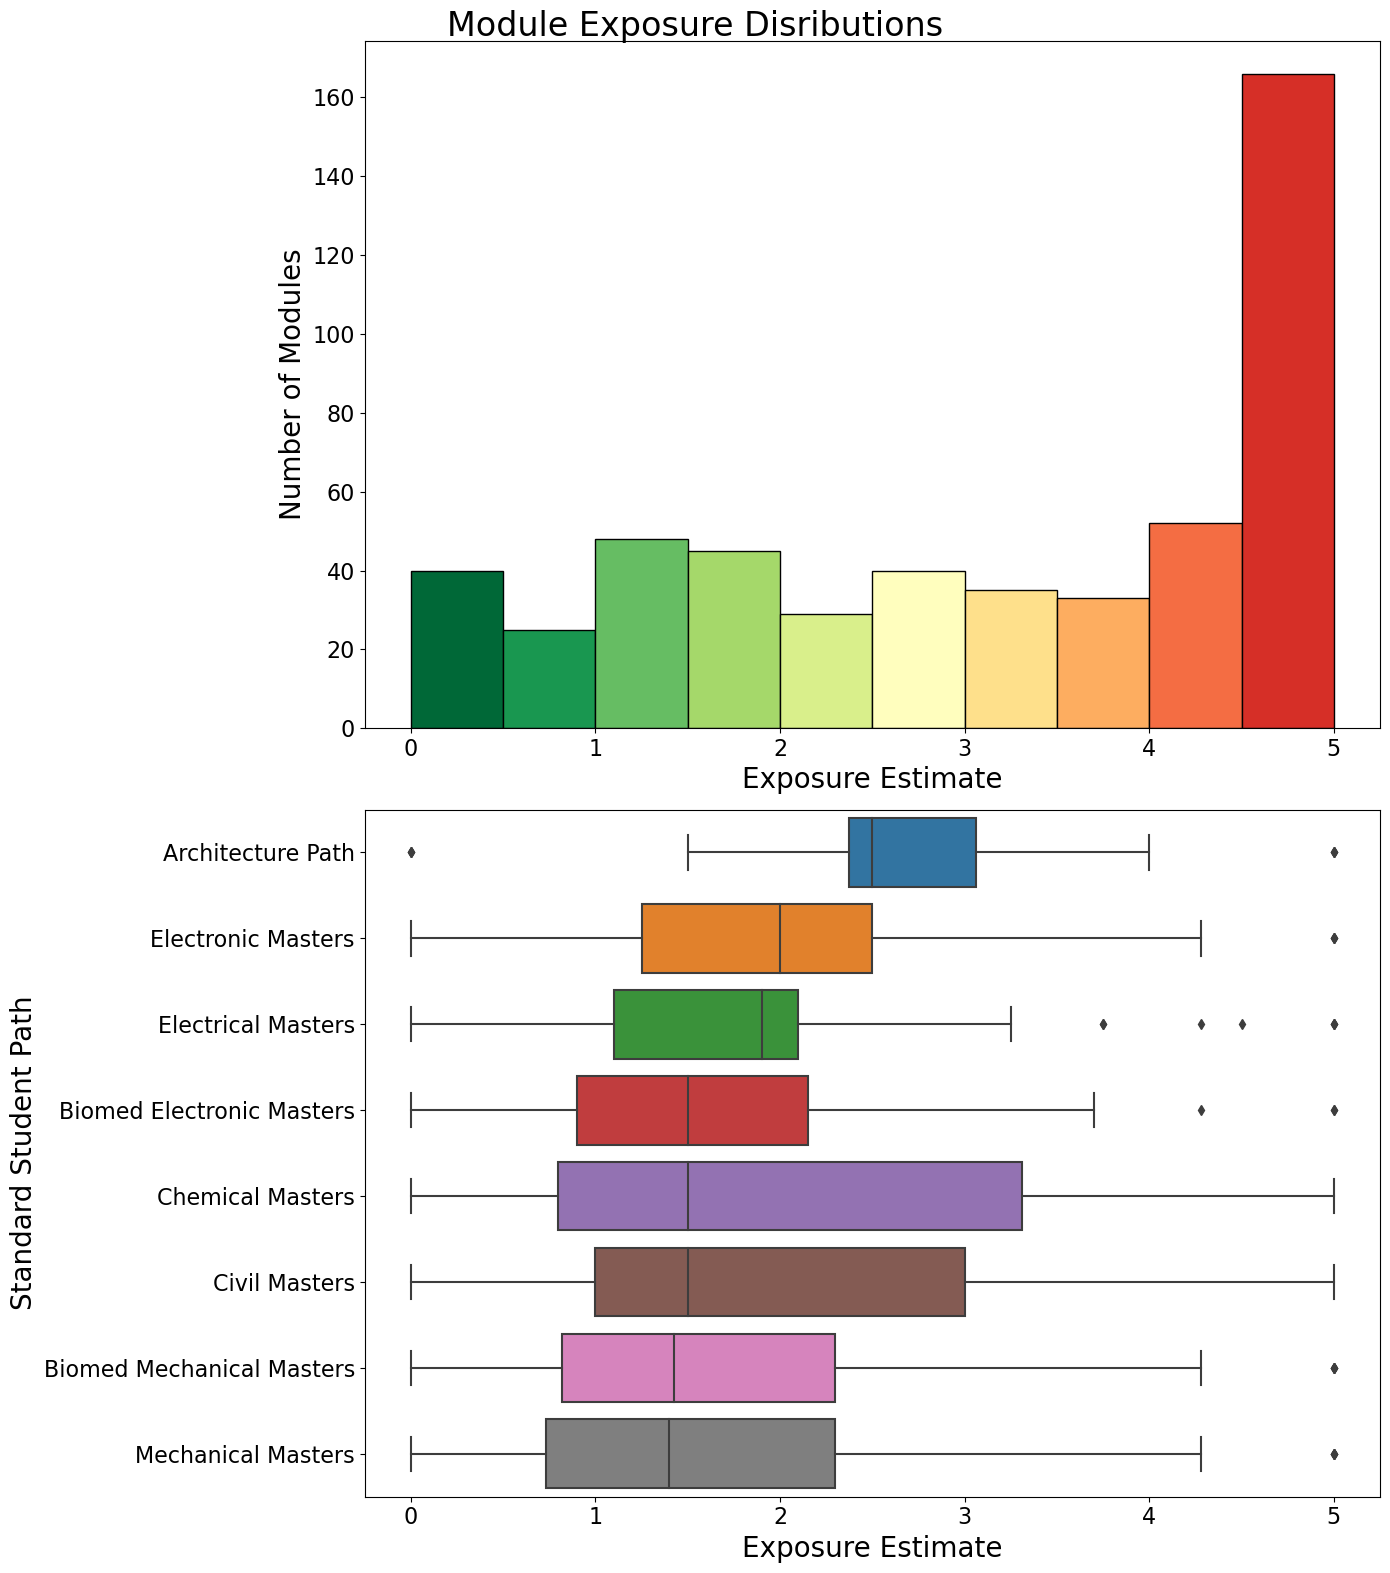

In [92]:
fig, (ax, bx)=plt.subplots(nrows=2, figsize=(14, 16))

plot=sns.histplot(data=modules, x="Exposure Estimate", \
             common_bins=True, ax=ax, bins=10)

for i, bin_ in enumerate(plot.patches):
    bin_.set_facecolor(plt.cm.RdYlGn_r((i/2)/5))
    
#Set the title
fig.suptitle("Module Exposure Disributions", fontsize=24)

#Format the Axes
ax.set_xlabel("Exposure Estimate", fontsize=20)
#ax.yticks(fontsize=16)
ax.set_ylabel("Number of Modules", fontsize=20)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
#ax.get_legend().remove()

##########
sns.boxplot(data=paths_df, x="Exposure Estimate", y="Path", ax=bx,
           order=["Architecture Path", "Electronic Masters", "Electrical Masters", "Biomed Electronic Masters",\
                  "Chemical Masters", "Civil Masters", "Biomed Mechanical Masters", "Mechanical Masters" ])

bx.set_xlabel("Exposure Estimate", fontsize=20)
#ax.yticks(fontsize=16)
bx.set_ylabel("Standard Student Path", fontsize=20)
bx.tick_params(axis='y', labelsize=16)
bx.tick_params(axis='x', labelsize=16)

fig.tight_layout()

#Set the path to save the graphs
dir_output=Path.Path("Graphs")
#Set the filename for th figure
dir_output=dir_output / "RiskAssessment" / "Summary"
dir_output.mkdir(parents=True, exist_ok=True)
filename= dir_output / ("Distibution.png")
plt.savefig(filename, dpi=1200)

In [19]:
print("Mean : %0.2f\n Mode : %0.2f\n Median : %0.2f" \
      %(modules["Exposure Estimate"].mean(), modules["Exposure Estimate"].mode(), modules["Exposure Estimate"].median()))

Mean : 3.08
 Mode : 5.00
 Median : 3.25


C:\Users\catha\AppData\Local\Temp\ipykernel_12096\3744374870.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Mean : %0.2f\n Mode : %0.2f\n Median : %0.2f" \


In [98]:
lowest=10
highest=-5

school_high=None
school_low=None

school_ratings={}

#Go through all the schools
for school in modules["School"].unique():
    #Only get the modules given by a certain school
    find=modules[modules["School"]==school]
    #Get the school average
    school_avg=find["Exposure Estimate"].mean()
    school_ratings[school]=school_avg
    
    #Update if the school average is higher than the current highest
    if school_avg > highest:
        #Update the highest and save the school 
        highest=school_avg
        school_high=school
        
    #Repeat above but for the lowest
    if school_avg < lowest:
        lowest=school_avg
        school_low=school
        
print("The school with the lowest mean is %s with a mean of %0.2f" %(school_low, lowest))
print("The school with the highest mean is %s with a mean of %0.2f" %(school_high, highest))

for school in modules["School"].unique():
    print("The rating for %s is %0.2f" %(school, school_ratings[school]))

The school with the lowest mean is Electrical & Electronic Eng with a mean of 2.22
The school with the highest mean is Architecture, Plan & Env Pol with a mean of 3.56
The rating for Architecture, Plan & Env Pol is 3.56
The rating for Biosystems & Food Engineering is 3.32
The rating for Chem & Bioprocess Engineering is 3.36
The rating for Civil Engineering is 2.91
The rating for Electrical & Electronic Eng is 2.22
The rating for Mechanical & Materials Eng is 2.65


In [50]:
from openpyxl.styles import PatternFill

#Set the columns we want
for_excel=modules[["Module Title", "Exposure Estimate", "Enrolled Students 22/23", "School", "Credits", "Level" ]]
#for_excel["Exposure Colour Rating"]=""

#We will set the colourmap we will use for the ratings
cmaps = plt.cm.RdYlGn_r

#def colour_cell(s):
#    rating=s
#    return ['background-color: %s' %cmaps(rating/5) if True]
    
#Apply the colour to the cell
#for_excel["Exposure Colour Rating"]=for_excel.style.apply({"Exposure Estimate" : lambda x:cmaps[x/5]})
for_excel=for_excel.style.background_gradient(subset=["Exposure Estimate"], cmap=cmaps, vmin=0, vmax=5)

for_excel.to_excel("Report.xlsx", index=True)

In [51]:
for_excel

,Module Title,Exposure Estimate,Enrolled Students 22/23,School,Credits,Level
Module Code,,,,,,
ARCT10010,Architectural Design I,2.500000,72,"Architecture, Plan & Env Pol",15.000000,1
ARCT10020,Architectural Design II,2.500000,61,"Architecture, Plan & Env Pol",15.000000,1
ARCT10030,Architecture & its Environment,5.000000,78,"Architecture, Plan & Env Pol",5.000000,1
ARCT10040,Intro. to Building Envelope,1.750000,61,"Architecture, Plan & Env Pol",5.000000,1
ARCT10070,Survey Course 1,3.000000,80,"Architecture, Plan & Env Pol",5.000000,1
ARCT10090,Perspectives on Architecture,2.000000,61,"Architecture, Plan & Env Pol",5.000000,1
ARCT10120,Into Practice,4.000000,64,"Architecture, Plan & Env Pol",5.000000,1
ARCT20010,Architectural Design IV,2.500000,65,"Architecture, Plan & Env Pol",15.000000,2
ARCT20020,The Indoor Environment,5.000000,68,"Architecture, Plan & Env Pol",5.000000,2
